In [1]:
# Application of Time2Feat on real dataset
import pickle
import time
import numpy as np
import pandas as pd

import sys
sys.path.append("../..")

from t2f.extraction.extractor import feature_extraction
from t2f.model.clustering import ClusterWrapper
from t2f.data.dataset import read_ucr_datasets
from t2f.selection.selection import cleaning
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score
import os
import warnings
warnings.filterwarnings("ignore")

from sb3_contrib.common.maskable.utils import get_action_masks

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from jqmcvi.base import dunn_fast

from normalization import ZScoreNormalization, MinMaxNormalization


# dataset_names = ["ERing", "RacketSports"]
dataset_names = ["ERing"]
transform_type = 'minmax'
model_type = 'Hierarchical'
train_size = 0.3
batch_size = 500
p = os.cpu_count()

silhouette_norm = ZScoreNormalization(
    score_function=silhouette_score,
    name='silhouette',
)

calinski_norm = ZScoreNormalization(
    score_function=calinski_harabasz_score,
    name='calinski_harabasz',
)

davies_bouldin_norm = ZScoreNormalization(
    score_function=davies_bouldin_score,
    maximize=False,  # minimum score is zero, with lower values indicating better clustering
    name='davies_bouldin',
)

dunn_index_norm = ZScoreNormalization(
    score_function=dunn_fast,
    name='dunn_index',
)

nameDataset = 'ERing'

extract_time = 0
ts_list, y_true = read_ucr_datasets(nameDataset=nameDataset)
n_clusters = len(set(y_true))  # Get number of clusters to find

# Create cluster model
model = ClusterWrapper(n_clusters=n_clusters, model_type=model_type, transform_type=transform_type)
print('Dataset shape: {}, Num of clusters: {}'.format(ts_list.shape, n_clusters))

# This side is dedicated for the Semi-Supervised
labels = {}
if train_size > 0:
    # Extract a subset of labelled mts to train the semi-supervised model
    idx_train, _, y_train, _ = train_test_split(
        np.arange(len(ts_list)), y_true, train_size=train_size)
    labels = {i: j for i, j in zip(idx_train, y_train)}
    # print('Number of Labels: {}'.format(len(labels)))

if not os.path.isfile("../../data/"+nameDataset+"_feats.pkl"):
    time_start = time.time()
    df_all_feats = feature_extraction(ts_list, batch_size, p)
    extract_time = time.time() - time_start
    file = open("../../data/"+nameDataset+"_feats.pkl", 'wb')
    pickle.dump(df_all_feats, file)

with open("../../data/"+nameDataset+"_feats.pkl", 'rb') as pickle_file:
    df_all_feats = pickle.load(pickle_file)

df_all_feats = cleaning(df_all_feats)

Dataset shape: (300, 65, 4), Num of clusters: 6


In [2]:
len(y_true)

300

In [ ]:
# Remove features with high correlation

<Axes: >

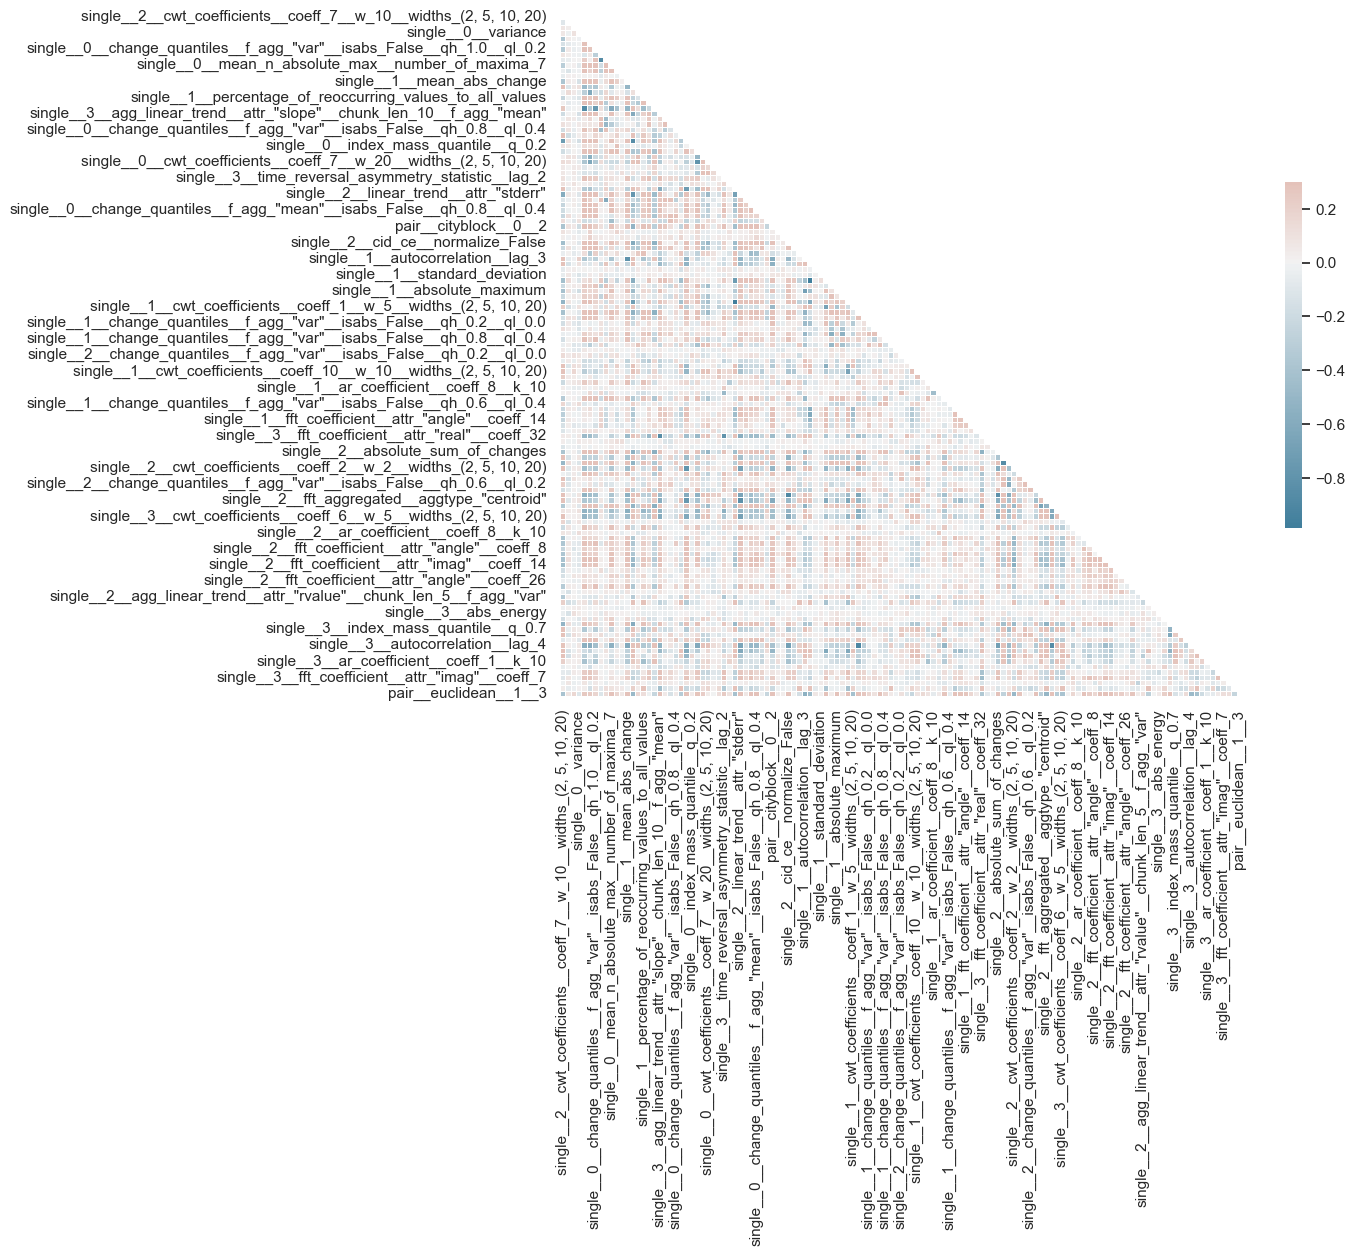

In [7]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset

# Compute the correlation matrix
corr = df_all_feats.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
df_all_feats.corr()

,"single__2__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)",single__0__has_duplicate_min,single__0__sum_values,single__0__variance,single__0__cid_ce__normalize_True,"single__0__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","single__0__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",single__0__count_above_mean,single__0__c3__lag_1,single__0__mean_n_absolute_max__number_of_maxima_7,...,single__3__autocorrelation__lag_4,"single__3__fft_aggregated__aggtype_""centroid""","single__3__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)",single__3__ar_coefficient__coeff_1__k_10,"single__3__fft_coefficient__attr_""real""__coeff_8","single__3__fft_coefficient__attr_""angle""__coeff_4","single__3__fft_coefficient__attr_""imag""__coeff_7","single__3__fft_coefficient__attr_""imag""__coeff_32",single__3__permutation_entropy__dimension_5__tau_1,pair__euclidean__1__3
"single__2__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)",1.000000,-0.098742,0.068873,0.063876,-0.369739,-0.137670,-0.339774,0.080891,-0.071356,-0.307069,...,0.289721,0.530983,0.757745,0.210926,-0.043025,-0.065695,-0.098180,-0.020710,0.041168,-0.397745
single__0__has_duplicate_min,-0.098742,1.000000,0.037626,-0.026431,0.040516,-0.062758,0.049660,0.025861,-0.046967,0.005159,...,0.035255,-0.133913,-0.155880,0.042711,-0.004758,-0.072979,0.075330,0.070993,-0.060519,0.073966
single__0__sum_values,0.068873,0.037626,1.000000,0.093597,0.007285,-0.028312,-0.032032,-0.006816,0.003375,0.021515,...,-0.030003,-0.040364,0.053014,0.015446,0.034408,0.049599,-0.018867,-0.034971,-0.028184,0.162631
single__0__variance,0.063876,-0.026431,0.093597,1.000000,-0.013163,-0.002784,-0.014525,-0.023341,0.000593,-0.074299,...,0.062187,0.053981,0.048829,0.038804,-0.043015,0.015257,-0.040878,-0.015172,0.015050,-0.106290
single__0__cid_ce__normalize_True,-0.369739,0.040516,0.007285,-0.013163,1.000000,0.403577,0.863029,-0.115793,0.223279,0.585553,...,-0.557159,-0.175032,-0.279297,-0.399409,-0.017544,0.232248,0.264344,0.075681,0.023719,0.257395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"single__3__fft_coefficient__attr_""angle""__coeff_4",-0.065695,-0.072979,0.049599,0.015257,0.232248,0.256391,0.174376,0.002500,-0.025147,0.054489,...,-0.202745,-0.206061,-0.035479,-0.052981,-0.232014,1.000000,0.335034,-0.035869,-0.250910,0.046737
"single__3__fft_coefficient__attr_""imag""__coeff_7",-0.098180,0.075330,-0.018867,-0.040878,0.264344,0.266503,0.183168,0.028687,-0.020032,0.111270,...,-0.174011,-0.291997,-0.103532,-0.099111,-0.140562,0.335034,1.000000,0.041728,-0.187954,0.114803
"single__3__fft_coefficient__attr_""imag""__coeff_32",-0.020710,0.070993,-0.034971,-0.015172,0.075681,-0.054921,0.056821,0.001575,-0.049911,0.009591,...,0.049329,-0.113685,0.043778,0.011845,-0.092444,-0.035869,0.041728,1.000000,-0.090055,0.120616
single__3__permutation_entropy__dimension_5__tau_1,0.041168,-0.060519,-0.028184,0.015050,0.023719,-0.167266,0.095732,-0.078664,0.113955,0.090163,...,0.136785,0.433052,-0.029838,-0.139682,0.185368,-0.250910,-0.187954,-0.090055,1.000000,-0.239469


In [3]:
df_all_feats

,"single__2__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)",single__0__has_duplicate_min,single__0__sum_values,single__0__variance,single__0__cid_ce__normalize_True,"single__0__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.0","single__0__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",single__0__count_above_mean,single__0__c3__lag_1,single__0__mean_n_absolute_max__number_of_maxima_7,...,single__3__autocorrelation__lag_4,"single__3__fft_aggregated__aggtype_""centroid""","single__3__cwt_coefficients__coeff_13__w_5__widths_(2, 5, 10, 20)",single__3__ar_coefficient__coeff_1__k_10,"single__3__fft_coefficient__attr_""real""__coeff_8","single__3__fft_coefficient__attr_""angle""__coeff_4","single__3__fft_coefficient__attr_""imag""__coeff_7","single__3__fft_coefficient__attr_""imag""__coeff_32",single__3__permutation_entropy__dimension_5__tau_1,pair__euclidean__1__3
0,-3.789208,0.0,-4.000000e-08,0.984615,1.781776,0.031386,0.054245,28.0,0.620670,1.993209,...,0.647525,5.514826,-0.451685,1.864429,0.341935,9.189848,-5.091015,0.169466,1.257133,13.800559
1,3.220561,0.0,4.000000e-08,0.984615,1.825094,0.028311,0.043782,37.0,0.105895,1.463667,...,0.674787,5.778572,2.634853,1.943972,-3.666923,-9.163185,-4.847317,-0.301651,0.928326,9.985044
2,-2.884435,1.0,-7.000000e-08,0.984615,2.047186,0.000000,0.074759,17.0,0.980277,1.771592,...,0.737411,5.153301,-0.184429,2.076270,0.972099,-84.026930,-3.935594,0.133855,1.033315,8.027030
3,-3.416770,1.0,-2.000000e-08,0.984615,3.278376,0.017235,0.162829,28.0,0.224739,1.582860,...,0.766371,5.353498,-0.627514,1.774516,2.288248,-45.571414,1.374018,-0.096721,1.443460,4.948962
4,-2.665901,1.0,1.600000e-07,0.984615,1.875053,-0.008984,0.054009,25.0,0.721274,1.763609,...,0.721205,5.971372,0.004713,1.808347,4.084969,-87.602980,-3.025836,-0.092863,1.353512,8.279043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,-3.762679,1.0,-3.000000e-08,0.984615,1.870566,-0.004160,0.046886,27.0,0.133926,1.344491,...,0.797142,3.710639,-0.696426,2.152906,-0.636870,-52.997541,-2.126923,-0.087124,1.033315,5.103436
296,-3.166290,1.0,-2.000000e-08,0.984615,1.563590,0.013901,0.043254,33.0,0.018340,1.280620,...,0.793528,3.570561,-0.377579,2.258383,-1.803397,-12.698735,2.278449,0.046564,0.688570,6.315040
297,-4.408025,1.0,1.000000e-07,0.984615,1.659845,-0.012124,0.038397,43.0,-0.681829,1.752150,...,0.785776,3.694896,-0.369828,2.096868,0.463694,-54.896177,-4.145728,0.037713,1.113016,10.160224
298,-5.469132,1.0,-4.000000e-08,0.984615,2.602705,-0.054838,0.121450,20.0,1.637366,2.304921,...,0.771171,5.446077,-0.659509,1.846067,-3.454280,4.531354,0.136866,-0.207900,1.128300,9.178287


In [25]:
features = df_all_feats[list(df_all_feats.columns[:1])]
y_pred = model.fit_predict(features)

In [26]:
y_pred

array([0, 1, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 3, 3, 2, 4, 0, 0, 0, 2, 0, 2,
       3, 0, 1, 0, 0, 2, 0, 0, 0, 4, 0, 0, 2, 0, 1, 0, 0, 0, 3, 2, 0, 2,
       0, 0, 0, 0, 1, 2, 3, 3, 1, 0, 0, 2, 0, 3, 0, 0, 0, 2, 3, 4, 0, 1,
       0, 1, 0, 2, 0, 0, 0, 2, 2, 3, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 3,
       0, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 3, 0, 0, 3, 0, 0, 0, 2, 0, 2, 2,
       0, 3, 0, 0, 3, 0, 4, 3, 0, 3, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 5, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 3, 4, 2, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 2, 0, 0, 1, 1, 2, 0, 3, 3, 4, 0, 4, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 4, 0, 2, 0,
       1, 0, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       3, 2, 0, 0, 2, 1, 2, 2, 3, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 3, 2, 1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0])